In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from ucimlrepo import fetch_ucirepo

1. The classification problem involves determining whether a person has heart disease or not. (?? elaborate but the fucking website is down)

In [4]:
heart_disease = pd.read_csv("https://raw.githubusercontent.com/PratheepaJ/datasets/refs/heads/master/ass6-dataset.csv")
heart_disease.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


2. It is necessary to transform the categorical variables in the dataset? or scale variable?? idk look at lecture notes

3. The dataset has 303 observations with 13 predictor variables and one response variable called `num`. 

The variable types are:  
age: integer  
sex: categorical  
cp: integer  
trestbps: integer  
chol: integer  
fbs: integer  
restecg: integer  
thalach: integer  
exang: integer  
oldpeak: continunous  
slope: integer  
ca: continuous  
thal: continuous  
num: integer (categorical response variable)

In [6]:
heart_disease.shape

(303, 14)

In [5]:
heart_disease.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca          float64
thal        float64
num           int64
dtype: object

In [14]:
heart_disease.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


<Axes: xlabel='num', ylabel='count'>

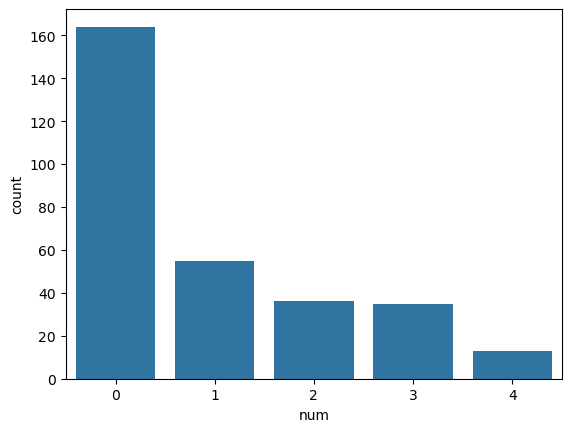

In [12]:
sns.countplot(x=heart_disease['num'])

<Axes: xlabel='age', ylabel='count'>

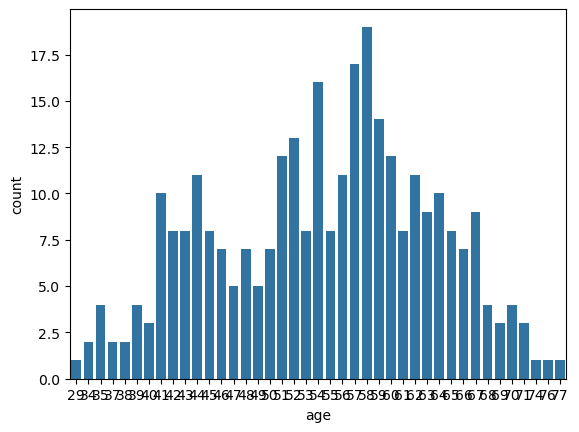

In [13]:
sns.countplot(x=heart_disease['age'])

4. Dataset transformation: turning `num` into a binary outcome

In [15]:
heart_disease['num'] = heart_disease['num'].apply(lambda x: 0 if x == 0 else 1)


5. Relationships between variables: use correlation plot. From the plot, most variables are not highly correlated. The most highly correlated variables are `oldpeak` and `slope` with a correlation of 0.58, signifying moderate correlation. With feature selection, this may inform our dimension reduction choices; if two variables are highly correlated we may remove one. However, a technique like principal component analysis is needed to confirm these choices. The variables that are the most correlated with the response variable are `cp`, `exang`, `oldpeak`, `ca`, and `thal`, all moderately correlated. It is also negatively correlated with `thalach`. For feature extraction, we may focus on using these variables as they seem to be the most useful in predicting an outcome of whether a person has heart disease or not. In general, none of the variables are very highly correlated, i.e. above 0.7. There is no clear indication that we should drop any one variable.

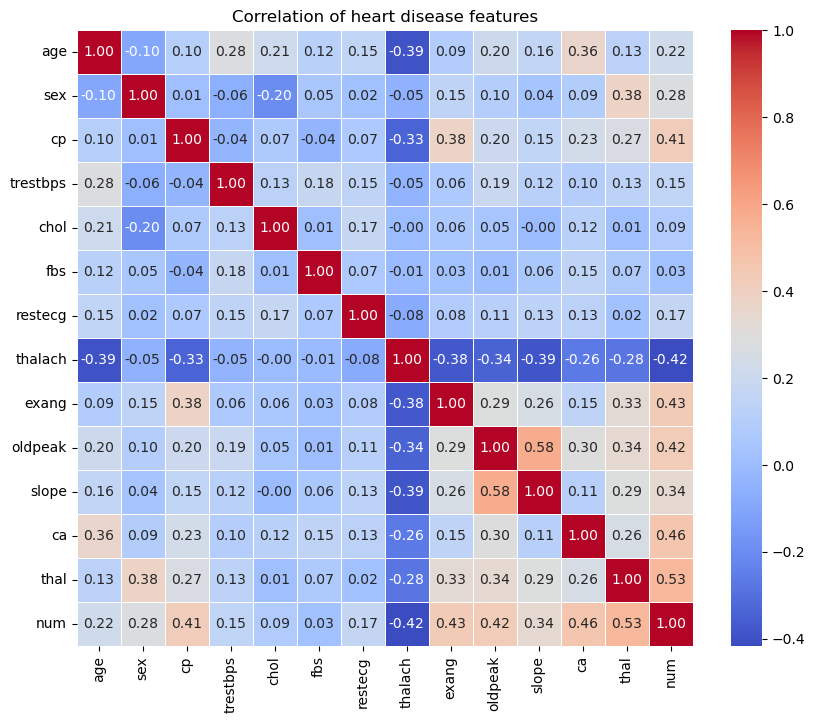

In [19]:
numerical_vars = heart_disease.select_dtypes(include=[np.number])
scaler = StandardScaler()
numerical_vars_scaled = pd.DataFrame(scaler.fit_transform(numerical_vars), columns=numerical_vars.columns)
corr_matrix = numerical_vars_scaled.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)

plt.title('Correlation of heart disease features')
plt.show()

6. There are 297 observations after dropping the missing values.

In [22]:
heart_disease.isna().sum() # some values are NA meaning missing

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num         0
dtype: int64

In [ ]:
# drop any values that are NA
heart_disease = heart_disease.dropna(axis=0)

In [25]:
heart_disease.isnull().sum() # some values are NA meaning missing

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64

7. Sub-group analysis; 

8. 

In [27]:
X = heart_disease.drop('num',axis=1)
Y = heart_disease['num']
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=1, stratify=Y)

9. The chosen classifiers are 